In [1]:
#Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import os
warnings.filterwarnings('ignore')

## Data Preparation

In [12]:
#Loading Data
os.chdir('/Volumes/PtatoBasket/ACIML/Outputs/Sheets_of_ML/')
DATA=pd.read_excel(r'ML2-PreMon.xlsx',sheet_name='Sheet1')
y=pd.Series(DATA.LWP)
X=DATA.loc[:,~DATA.columns.isin(['LWP','Unnamed: 0'])]#Select Everything Other than LWP

#Split dataset into training set and test set
X_train,X_test_whole,y_train,y_test_whole=train_test_split(X,y,test_size=0.3, random_state=42)#70% training and 30% test
X_testA,X_testB,y_testA,y_testB=train_test_split(X_test_whole,y_test_whole,test_size=0.5, random_state=42)#15% and 15%  for 2 fold verification



In [6]:
# %%script echo skipping
X.head()

,PBLH,WindDirection-850,MeanWind-850,RH,VerticalVelocity-850,SMOKE-AOD,DUST-AOD,AI,PrecipitableVapour,LTS,Nd,CloudRadius,CTP,CTT,COT
0,931.393555,287.576355,4.266716,21.915994,0.007169,0.083552,0.062997,0.119241,3.353,14.974854,75.475395,12.620000,958.100014,298.029993,4.74
1,910.018555,274.132782,5.148071,15.597591,0.019353,0.106163,0.059405,0.156119,3.252,15.336151,75.765414,13.360000,948.100014,297.749993,3.43
2,945.707703,266.521637,3.435282,32.735769,0.042235,0.078221,0.051478,0.111619,4.055,14.338867,23.799914,18.040000,576.800009,259.059994,3.04
3,804.874451,293.850555,4.603513,55.268201,0.047287,0.113682,0.046840,0.163343,4.394,14.156128,12.021745,25.979999,744.700011,276.749994,0.80
4,776.124451,294.297058,4.175772,44.787844,0.051745,0.112496,0.050975,0.163755,3.948,14.325378,9.900121,16.930000,558.700008,254.839994,1.84


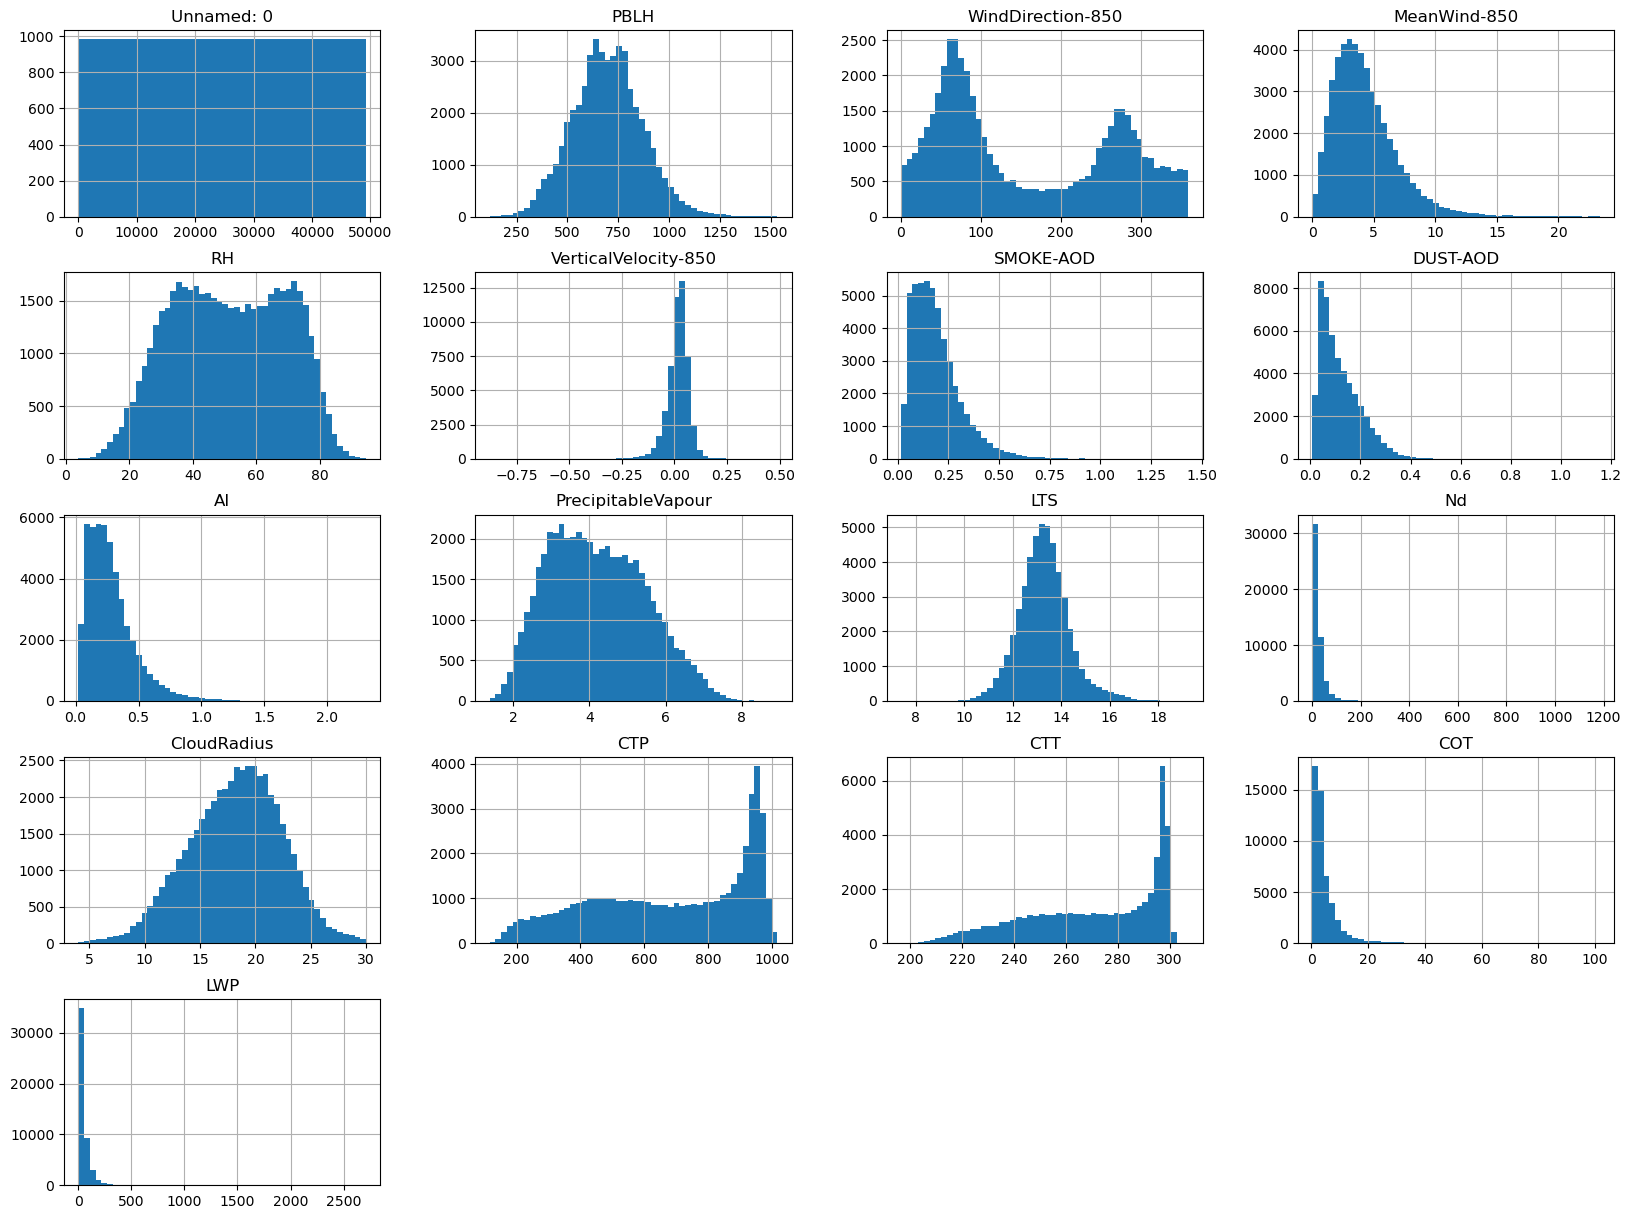

In [7]:
import matplotlib.pyplot as plt
DATA.hist(bins=50, figsize=(20,15))
plt.show()

## Model training

### For GBRT

In [5]:
%%script echo skipping
#Create gradientboost Regressor object
from sklearn.ensemble import GradientBoostingRegressor
myModel=GradientBoostingRegressor(max_depth=8,n_estimators=150,learning_rate=0.05)

Couldn't find program: 'echo'


### For RandomForest

In [8]:
#Create RandomForest Regressor objec
from sklearn.ensemble import RandomForestRegressor
myModel=RandomForestRegressor(random_state=42)

### to See the params

In [5]:
myModel.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Model Running

In [13]:
#Training
model=myModel.fit(X_train,y_train)
#Testing
y_pred=model.predict(X_testA)

## Model Evalutation

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score,f1_score

In [14]:
methods=['R-Squared', 'Adjusted R-Squared', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'RMSE']
values=[]

values.append(r2_score(y_testA,y_pred)) #1.R-Squared
values.append(1 - (1-model.score(X_testA, y_testA))*(len(y_testA)-1)/(len(y_testA)-X_testA.shape[1]-1))#2.Adjusted R-Squared
values.append(mean_absolute_error(y_testA, y_pred))#3.MAE
values.append(mean_squared_error(y_testA, y_pred))#4.MSE
values.append(np.sqrt(mean_squared_error(y_testA, y_pred)))#5.RMSE
# values.append(f1_score(y_test,y_pred))#6.F1 Score

eval_df = pd.DataFrame({'Method Name' : methods, 'Values': values})
eval_df

,Method Name,Values
0,R-Squared,0.392963
1,Adjusted R-Squared,0.390580
2,Mean Absolute Error (MAE),18.777448
3,Mean Squared Error (MSE),1061.053346
4,RMSE,32.573814


## Ploting the Importance

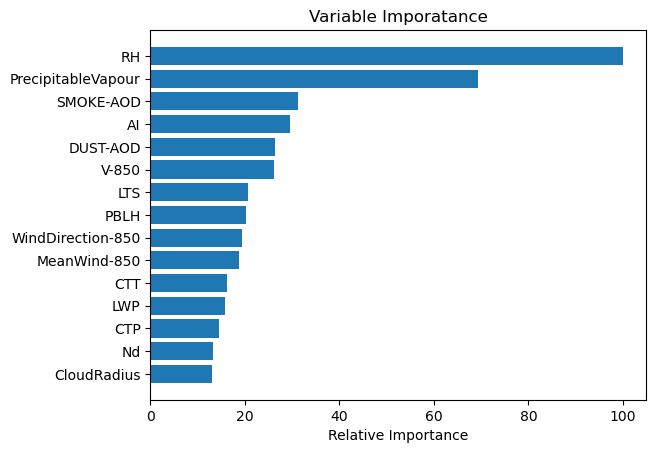

In [59]:
import matplotlib.pyplot as plt

#plot feature importance
feature_importance = model.feature_importances_

#make importances relative to mac importance
feature_importance=100.0 * (feature_importance/feature_importance.max())
sorted_idx=np.argsort(feature_importance)
pos=np.arange(sorted_idx.shape[0])+.5
plt.barh(pos, feature_importance[sorted_idx],align='center')
plt.yticks(pos, DATA.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Imporatance')
plt.show()

## Tuning hyperparameters

### For GBRT

In [12]:
%%script echo skipping
from sklearn.model_selection import GridSearchCV
LR={'learning_rate':[0.15,0.10,0.05],'n_estimators':[100,150,200,250]}
tuning=GridSearchCV(estimator=myModel,
            param_grid=LR,scoring='r2')
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_


Couldn't find program: 'echo'



Selected:
({'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250},0.3665469426033763)


### For RandomForest

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [35]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['sqrt'], 'max_depth': [2, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [36]:
from sklearn.model_selection import RandomizedSearchCV
model = myModel
rf_RandomGrid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [60]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33; total time=   1.4s

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 2, 3, 4, 5, 6, 6, 7, 8,
                                                      9, 10, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [61]:
params=rf_RandomGrid.best_params_
params

{'n_estimators': 80,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': True}

In [62]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test AccuracyA  - : {rf_RandomGrid.score(X_testA,y_testA):.3f}')
print (f'Test AccuracyB  - : {rf_RandomGrid.score(X_testB,y_testB):.3f}')

Train Accuracy - : 0.460
Test AccuracyA  - : 0.367
Test AccuracyB  - : 0.365


## Doing the validation with best params

In [40]:
#WithBestParams
myModel=RandomForestRegressor(random_state=42,
                        n_estimators=params['n_estimators'],
                        min_samples_split=params['min_samples_split'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_features='sqrt',
                        max_depth=None,bootstrap=False)

#Training
model=myModel.fit(X_train,y_train)
#Testing
y_pred=model.predict(X_testA)

In [41]:
methods=['R-Squared', 'Adjusted R-Squared', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'RMSE']
values=[]

values.append(r2_score(y_testA,y_pred)) #1.R-Squared
values.append(1 - (1-model.score(X_testA, y_testA))*(len(y_testA)-1)/(len(y_testA)-X_testA.shape[1]-1))#2.Adjusted R-Squared
values.append(mean_absolute_error(y_testA, y_pred))#3.MAE
values.append(mean_squared_error(y_testA, y_pred))#4.MSE
values.append(np.sqrt(mean_squared_error(y_testA, y_pred)))#5.RMSE
# values.append(f1_score(y_test,y_pred))#6.F1 Score

eval_df = pd.DataFrame({'Method Name' : methods, 'Values': values})
eval_df

,Method Name,Values
0,R-Squared,0.384110
1,Adjusted R-Squared,0.380360
2,Mean Absolute Error (MAE),16.476579
3,Mean Squared Error (MSE),772.404308
4,RMSE,27.792163


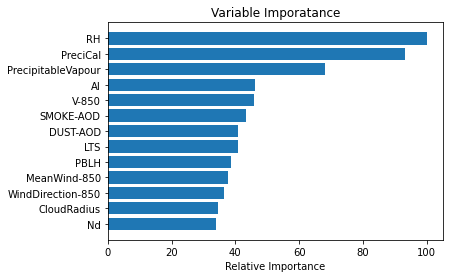

In [21]:
import matplotlib.pyplot as plt

#plot feature importance
feature_importance = model.feature_importances_

#make importances relative to mac importance
feature_importance=100.0 * (feature_importance/feature_importance.max())
sorted_idx=np.argsort(feature_importance)
pos=np.arange(sorted_idx.shape[0])+.5
plt.barh(pos, feature_importance[sorted_idx],align='center')
plt.yticks(pos, DATA.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Imporatance')
plt.show()